<h1>Jupyter notebook with the step-by-step set up of Opyrability with AVEVA Process Simulation</h1>

<h2>Step 1: Necessary imports for connection with APS and for Operability computations:</h2>

<h4> APS connection import</h4>

In [25]:
import simcentralconnect #AVEVA PROCESS SIMULATION REQUIRED IMPORT TO ENABLE CONNECTION

<color><red><i>This import is essential to enable the communication with APS. Once you installed and configured you APS, you should be able to find the Scripting Interface files. In it, a step-by-step readme file guides the user through enabiling the connection.</i></color></red>

In [26]:
import numpy as np
from opyrability import AIS2AOS_map, multimodel_rep, OI_eval #Operability algorigthms import from Opyrability library
from scipy.io import savemat

# Instantiating the required interfaces for the scripting interface

sc = simcentralconnect.connect().Result
sm = sc.GetService("ISimulationManager")
vm = sc.GetService("IVariableManager")
snap = sc.GetService("ISnapshotManager")

# Example of how to set options.  API logging is ON by default.  Disabled by changing to 'false'
sc.SetOptions(repr({'Timeout': 100000, 'EnableApiLogging': 'false'}))

SimCentral.Client.Auto loaded from: PATH


<h2>Step 2: Calling the simulation file you want to work with:</h2>

In [27]:
simFile = "Mem_DAC_withouttrends"
simName = "Sim 93" #WARNING: Sometimes APS might rename your simulation as its opened so always make sure the name of the simulation you are working with aligns with the current opened simulation
nameSnap = "steady" #Note: This is only required in case the user wants to set the simulation to a specific snapshot

<h2>Step 3: Function for double checking if simulation exist:</h2>

In [28]:
def open_simulation(simName):
    opened = False
    try:
        opened = sm.OpenSimulation(simName).Result
    except System.AggregateException as ex:
        if not isinstance(ex.InnerException, System.InvalidOperationException) \
                or "simulation doesn't exists" not in ex.InnerException.Message:
            raise
    return opened



open_simulation(simName)

True

<h2>Step 4: Process model function to communicate with APS and Opyrability:</h2>

In [ ]:
def M(u):

    y = np.zeros(2) #Prealocating outputs
     
    # Membrane properties case
    
    vm.SetVariableValue(simName, "MDAC1.QCO2", u[0], "", ).Result
    vm.SetVariableValue(simName, "MDAC1.Selectivity", u[1], "", ).Result
    vm.SetVariableValue(simName, "MDAC2.QCO2", u[0], "", ).Result
    vm.SetVariableValue(simName, "MDAC2.Selectivity", u[1], "", ).Result

    # --------- Checking solution status ----------------------------- 
    simstat = sm.GetSimulationStatus(simName).Result
    print(str(simstat[0]),str(simstat[1]),str(simstat[2]))
    print(u[0])
    if (simstat[2]):
        flag_conv = True
    else:
        flag_conv= False

    if flag_conv is True:
        
        # ------------------ PRODUCTIVITY VARIABLES -----------------------------------------

        feed_flow = vm.GetVariableValue(simName, "Air_feed.F", "kmol/h").Result
        prod_F1 = vm.GetVariableValue(simName, "Permeate1.F", "kmol/h", ).Result
        purity1 =  vm.GetVariableValue(simName, "Permeate1.z[CO2]", "mol frac", ).Result
        Temp1 = vm.GetVariableValue(simName, "Permeate1.T", "K", ).Result   
        prod_F2 = vm.GetVariableValue(simName, "Product.F", "kmol/h", ).Result            
        purity2 =  vm.GetVariableValue(simName, "Product.z[CO2]", "mol frac", ).Result                
        Temp2 = vm.GetVariableValue(simName, "Permeate2.T", "K", ).Result
        prod_W = vm.GetVariableValue(simName, "Product.W", "kg/h", ).Result
        
        # --------------------- ENERGY VARIABLES ----------------------------------------
        
        comp1 = vm.GetVariableValue(simName, "Comp1.Power", "kW", ).Result
        hx1 = vm.GetVariableValue(simName, "Cooler1.Duty", "kW", ).Result    
        e1 = vm.GetVariableValue(simName, "Heater1.Duty", "kW", ).Result
        blower = vm.GetVariableValue(simName, "Blower.Power", "kW", ).Result        
        comp2 = vm.GetVariableValue(simName, "Comp2.Power", "kW", ).Result
        hx2 = vm.GetVariableValue(simName, "Cooler2.Duty", "kW", ).Result                         
        e2 = vm.GetVariableValue(simName, "Heater2.Duty", "kW", ).Result     
        
        # ---------------- AOS VARIABLES --------------------------------------------------
                
        # -------------------- Purity vs. Recovery case study ----------------------
        y[0] = purity2*100
        y[1] = 100*((prod_F2*purity2) / (feed_flow*0.000420))

        # -------------------- Purity vs. Energy consumed case study ----------------------
        #energy = abs(comp1) + abs(hx1) + abs(e1)+ abs(blower)+  abs(comp2) + abs(hx2) + abs(e2) #Energy in kWh
        #y[1] = energy/(prod_W*purity2)

        if flag_conv is True:
                             
            # ------------------- MEMBRANE PROPERTIES CASE -------------------------------
            vm.SetVariableValue(simName, "MDAC1.QCO2", u[0], "", ).Result
            vm.SetVariableValue(simName, "MDAC1.Selectivity", u[1], "", ).Result  
            vm.SetVariableValue(simName, "MDAC2.QCO2", u[0], "", ).Result
            vm.SetVariableValue(simName, "MDAC2.Selectivity", u[1], "", ).Result  
            
            # --------- Checking solution status again-----------------------------        
            simstat = sm.GetSimulationStatus(simName).Result
            print(u[0],"failed")
            if (simstat[2]):
                flag_conv = True
            else:
                flag_conv= False
            
            if flag_conv is True:
            
                # ------------------ PRODUCTIVITY VARIABLES -----------------------------------------

                feed_flow = vm.GetVariableValue(simName, "Air_feed.F", "kmol/h").Result
                prod_F1 = vm.GetVariableValue(simName, "Permeate1.F", "kmol/h", ).Result
                purity1 =  vm.GetVariableValue(simName, "Permeate1.z[CO2]", "mol frac", ).Result
                Temp1 = vm.GetVariableValue(simName, "Permeate1.T", "K", ).Result                
                prod_F2 = vm.GetVariableValue(simName, "Product.F", "kmol/h", ).Result            
                purity2 =  vm.GetVariableValue(simName, "Product.z[CO2]", "mol frac", ).Result                
                Temp2 = vm.GetVariableValue(simName, "Permeate2.T", "K", ).Result                
                prod_W = vm.GetVariableValue(simName, "Product.W", "kg/h", ).Result
                
                # --------------------- ENERGY VARIABLES ----------------------------------------
                                
                comp1 = vm.GetVariableValue(simName, "Comp1.Power", "kW", ).Result
                hx1 = vm.GetVariableValue(simName, "Cooler1.Duty", "kW", ).Result
                e1 = vm.GetVariableValue(simName, "Heater1.Duty", "kW", ).Result
                blower = vm.GetVariableValue(simName, "Blower.Power", "kW", ).Result                
                comp2 = vm.GetVariableValue(simName, "Comp2.Power", "kW", ).Result
                hx2 = vm.GetVariableValue(simName, "Cooler2.Duty", "kW", ).Result                  
                e2 = vm.GetVariableValue(simName, "Heater2.Duty", "kW", ).Result
                
                # ---------------- AOS VARIABLES --------------------------------------------------
                
                # -------------------- Purity vs. Recovery case study ----------------------
                y[0] = purity2*100
                y[1] = 100*((prod_F2*purity2) / (feed_flow*0.000420))

                # -------------------- Purity vs. Energy consumed case study ----------------------
                #energy = abs(comp1) + abs(hx1) + abs(e1)+ abs(blower)+  abs(comp2) + abs(hx2) + abs(e2) #Energy in kWh
                #y[1] = energy/(prod_W*purity2)
                
            else:
                pass
            
            
    return y #Returning outputs for the Operability study

<h2>Step 5: Defining Operability study </h2>

True True False
3.35e-08
True True False
3.35e-08
True True False
1.700125e-06
True True False
3.3667500000000004e-06
True True False
5.033375e-06
True True False
6.7e-06
True True False
3.35e-08
True True False
1.700125e-06
True True False
3.3667500000000004e-06
True True False
5.033375e-06
True True False
6.7e-06
True True False
3.35e-08
True True False
1.700125e-06
True True False
3.3667500000000004e-06
True True False
5.033375e-06
True True False
6.7e-06
True True False
3.35e-08
True True False
1.700125e-06
True True False
3.3667500000000004e-06
True True False
5.033375e-06
True True False
6.7e-06
True True False
3.35e-08
True True False
1.700125e-06
True True False
3.3667500000000004e-06
True True False
5.033375e-06
True True False
6.7e-06


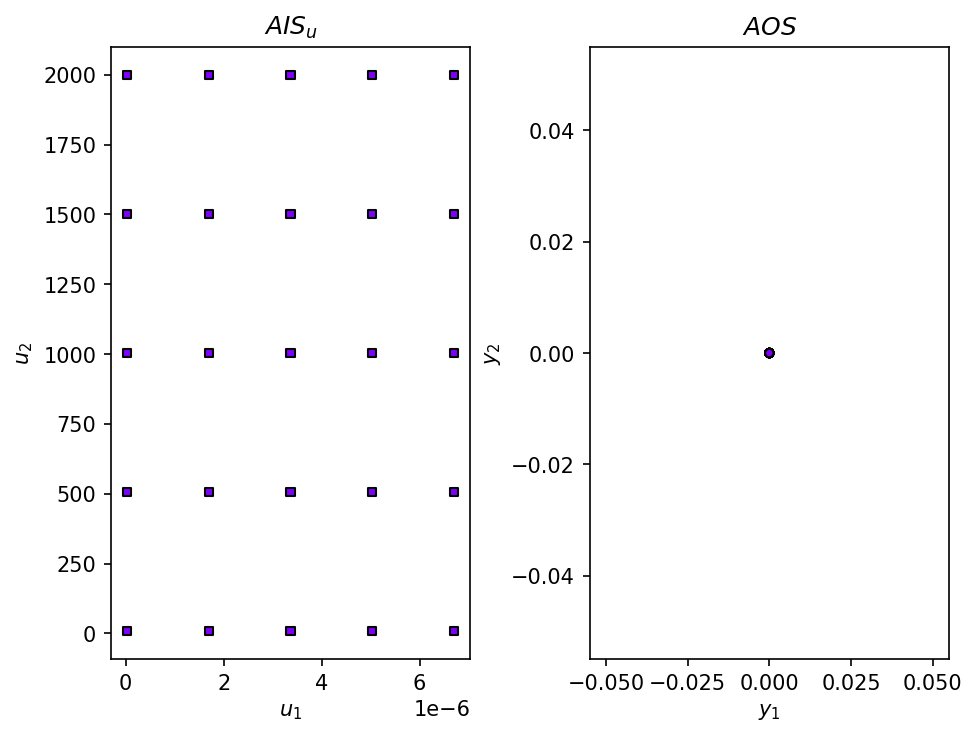

In [30]:
#---------------------- OPERABILIY STUDY --------------------------------------------------

AIS_bounds =  np.array([[3.35e-8, 6.7e-06],[8, 2000]]) #AIS bounds definition for the 2 inputs x 2 outputs case study


AIS_resolution =  [5,5] #AIS discretization definition for the 2 inputs x 2 outputs case study

AIS, AOS = AIS2AOS_map(M, AIS_bounds, AIS_resolution) #Forwad mapping call for the 2 inputs x 2 outputs case study
AIS_human = AIS.reshape(AIS.shape[0]*AIS.shape[1],-1)
AOS_human = AOS.reshape(AOS.shape[0]*AOS.shape[1],-1)